In [1]:
import os
import json
import ast
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pathlib
import pprint
import scipy
from datetime import datetime
import sys
import shutil
import random

# Prep

## Training Catalog

In [2]:
DRL_TRAININGS = {
    "reward_sharpe_ratio_0": "20230429_200721",
    "reward_differential_sharpe_ratio_0": "20230424_070731",
    "compute_reward_from_tutor_0": "20230429_200559",
    "reward_profit_0": "20230429_110440",
    "reward_profit_1": "20230423_174023",
    "reward_profit_2": "20230420_083508", # trial 8
    "reward_profit_3": "20230420_195053", # trial 9
}

DQN_TRAININGS = {
    "reward_sharpe_ratio_0": "20230427_165557",
    "reward_differential_sharpe_ratio_0": "20230427_083418",
    "compute_reward_from_tutor_0": "20230427_083632",
    "reward_profit_0": "20230425_145617",

    "reward_differential_sharpe_ratio_1": "20230423_114422",
    "compute_reward_from_tutor_1": "20230421_181519",
    "reward_profit_1": "20230423_231505",
    "reward_profit_2": "20230422_122001",
    "reward_profit_3": "20230421_001115",
}


**Prep data folder for notebook** 
 - Copy all trainings to one folder.
 - Set folder to var base_folder 
Folder should look like:
```
base_folder/
| 20230429_200721
| 20230424_070731
| ...
```

In [3]:
# TODO: copy all trainings to one folder 
base_folder = pathlib.Path(r'C:\\Users\\romy_\\Documents\\arnolduni\\ai_trader_data')

algo='drl'
# algo='dqn'

data_folder = os.path.join(base_folder, '20230420_195053')
print(data_folder, os.path.exists(data_folder))

trial_name = [x for x in os.listdir(data_folder) if os.path.isdir(os.path.join(data_folder, x))][0]

data = json.load(open(os.path.join(data_folder, trial_name, 'params.json')))
print(data['reward_function'])

C:\Users\romy_\Documents\arnolduni\ai_trader_data\20230420_195053 True
reward_profit


## Helper Functions

In [4]:
def get_train_data(path_to_folders, algorithm, trial=0, return_df=True):
    trial_name = [x for x in os.listdir(path_to_folders) if os.path.isdir(os.path.join(data_folder, x))]
    if trial_name:
        trial_name = trial_name[0]
    else:
        trial_name = f"{algorithm.upper()}_trial_{trial}"
    r_funcs = []

    data = json.load(open(os.path.join(path_to_folders, trial_name, 'params.json')))
    r_funcs.append(data['reward_function'])
    pprint.pprint(data)

    path_to_episode_files = os.path.join(path_to_folders, trial_name, "episodes")
    files_ep = os.listdir(path_to_episode_files)
    ep_li = []
    for file in files_ep:
        df = pd.read_csv(os.path.join(path_to_episode_files, file), sep=";", index_col=None, header=0)
        ep_li.append(df)
    ep_frame = pd.concat(ep_li, axis=0, ignore_index=True)

    files_tr = os.listdir(os.path.join(path_to_folders, trial_name))
    tr_li = []
    for filename in files_tr:
        if filename.endswith(".csv"):
            df = pd.read_csv(os.path.join(path_to_folders, trial_name, filename), sep=";", index_col=None, header=0)
            tr_li.append(df)
    train_frame = pd.concat(tr_li, axis=0, ignore_index=True)

    if return_df:
        return train_frame, ep_frame
    else:
        return files_tr, files_ep


In [5]:
def get_profits_every_episode(dataframe):
    profit = []
    episode = []
    delta_btc_price = []
    grouped = dataframe.groupby('episode')
    for name, group in grouped:
        btc_price_init = group.iloc[0]['btc_price']
        btc_price_final = group.iloc[-1]['btc_price']
        wallet_value_init = group.iloc[0]['wallet_value']
        wallet_value_final = group.iloc[-1]['wallet_value']
        episode.append(int(name))
        profit.append(wallet_value_final - wallet_value_init)
        delta_btc_price.append(btc_price_final - btc_price_init)

    return episode, profit, delta_btc_price

In [6]:
def plot_overviews(episode, profit, delta_btc_price):
    print("np.mean(profit), np.std(profit), np.mean(delta_btc_price), np.std(delta_btc_price)")
    print(np.mean(profit), np.std(profit), np.mean(delta_btc_price), np.std(delta_btc_price))
    profit_diff = [profit[i] - delta_btc_price[i] for i in range(len(episode))]
    fig, ax = plt.subplots(2,2, figsize=(12,12))

    # Fig 1 profits and BTC prices delta
    ax[0][0].plot(episode,profit, 'x')
    ax[0][0].plot(episode,delta_btc_price, '+')
    ax[0][0].set_title("Profit and BTC Prices Variation over Episode")
    ax[0][0].set_xlabel("Episodes [-]")
    ax[0][0].set_ylabel("Values [Eur]")
    ax[0][0].grid()

    tmp = np.convolve(profit_diff, np.ones(5)/5, mode='valid')
    # Fig 2 profit dif to btc and BTC prices delta
    ax[0][1].plot(profit_diff)
    # ax[0][1].plot(tmp)
    # ax[0][1].hist(profit_diff, bins=20)
    ax[0][1].set_title("Comparison from NN to Buy-&-Hold over Episodes")
    ax[0][1].set_xlabel("Episodes [-]")
    ax[0][1].set_ylabel("Values [Eur]")
    ax[0][1].grid()

    # Fig 3 profit diff to btc and BTC prices delta moving average
    tmp = np.convolve(profit, np.ones(5)/5, mode='valid')
    tmp_btc = np.convolve(delta_btc_price, np.ones(5)/5, mode='valid')
    ax[1][0].plot(tmp, label="RL")
    ax[1][0].plot(tmp_btc, label="B&H")
    ax[1][0].set_title("Moving Average Comparison from NN to Buy-&-Hold over Episodes")
    ax[1][0].set_xlabel("Episodes [-]")
    ax[1][0].set_ylabel("Values [Eur]")
    ax[1][0].legend()
    ax[1][0].grid()

    ax[1][1].set_title("Violin Plot: Profits BTC-Delta, Strategy Deltas")
    ax[1][1].violinplot([profit, delta_btc_price, profit_diff], showmeans=True)
    ax[1][1].set_xticklabels([" ", "Profit"," ",  "BTC Delta"," ", "Profit Diff"])
    ax[1][1].grid()
    plt.show()

In [7]:
def plot_episode_info(dataframe, ep):
    fig, ax = plt.subplots(4,1, figsize=(10,10), sharex=True)

    y = dataframe.btc_price[ep*670:(ep+1)*670].to_numpy()
    ax[0].plot(y)
    ax[0].set_title("btc price")
    ax[0].set_ylabel("Eur")
    ax[0].grid()

    y = [np.fromstring(x[1:-1], dtype=np.float, sep=' ') for x  in dataframe.reward[ep*670:(ep+1)*670]]
    ax[1].plot(y)
    ax[1].set_title("Rewards")
    ax[1].set_ylabel("[-]")
    ax[1].grid()
    
    ax[2].plot(dataframe.wallet_value[ep*670:(ep+1)*670].to_numpy())
    ax[2].set_title("wallet value")
    ax[2].set_ylabel("EUR")
    ax[2].grid()
    
    y = [np.fromstring(x[1:-1], dtype=np.float, sep=' ') for x  in dataframe.action[ep*670:(ep+1)*670]]
    ax[3].plot(y)
    ax[3].set_title("actions")
    ax[3].set_ylabel("[-]")
    ax[3].set_xlabel("Time-step [-]")
    ax[3].grid()
    plt.show()


# Data Analysis

## Data Analysis: 20230429_200721

In [8]:
data_folder = os.path.join(base_folder, '20230429_200721')
train_frame, ep_frame = get_train_data(data_folder, algorithm=algo, trial=0, return_df=True)
print(train_frame.shape, ep_frame.shape)

{'action_domain': [0.0, 1.0],
 'action_space': 1,
 'algorithm': 'DRL_trial_0',
 'asset': 'BTC',
 'batch_size': 16,
 'data_source': 'BTC_histData_dt1800.0s_20220825_0629',
 'episodes': 50,
 'epoch': 2,
 'epsilon': 0.5,
 'epsilon_decay': 0.75,
 'epsilon_final': 0.01,
 'fee': 0.001,
 'from_checkpoint': None,
 'gamma': 0.95,
 'learning_rate': 1e-07,
 'loss_method': 'stantard_loss',
 'money': 10000,
 'obs_space': [8, 20],
 'reward_function': 'reward_sharpe_ratio',
 'runs_p_eps': 5,
 'trainer': 'DRLTrainer'}
(167250, 9) (167500, 23)


In [9]:
episode, profit, delta_btc_price = get_profits_every_episode(ep_frame)
profit_diff = [profit[i] - delta_btc_price[i] for i in range(len(episode))]

np.mean(profit), np.std(profit), np.mean(delta_btc_price), np.std(delta_btc_price)
-382.18520000000007 496.7437141296908 48.80179999999993 5706.867794250254


C:\Users\romy_\AppData\Local\Temp\ipykernel_8440\383711849.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1][1].set_xticklabels([" ", "Profit"," ",  "BTC Delta"," ", "Profit Diff"])


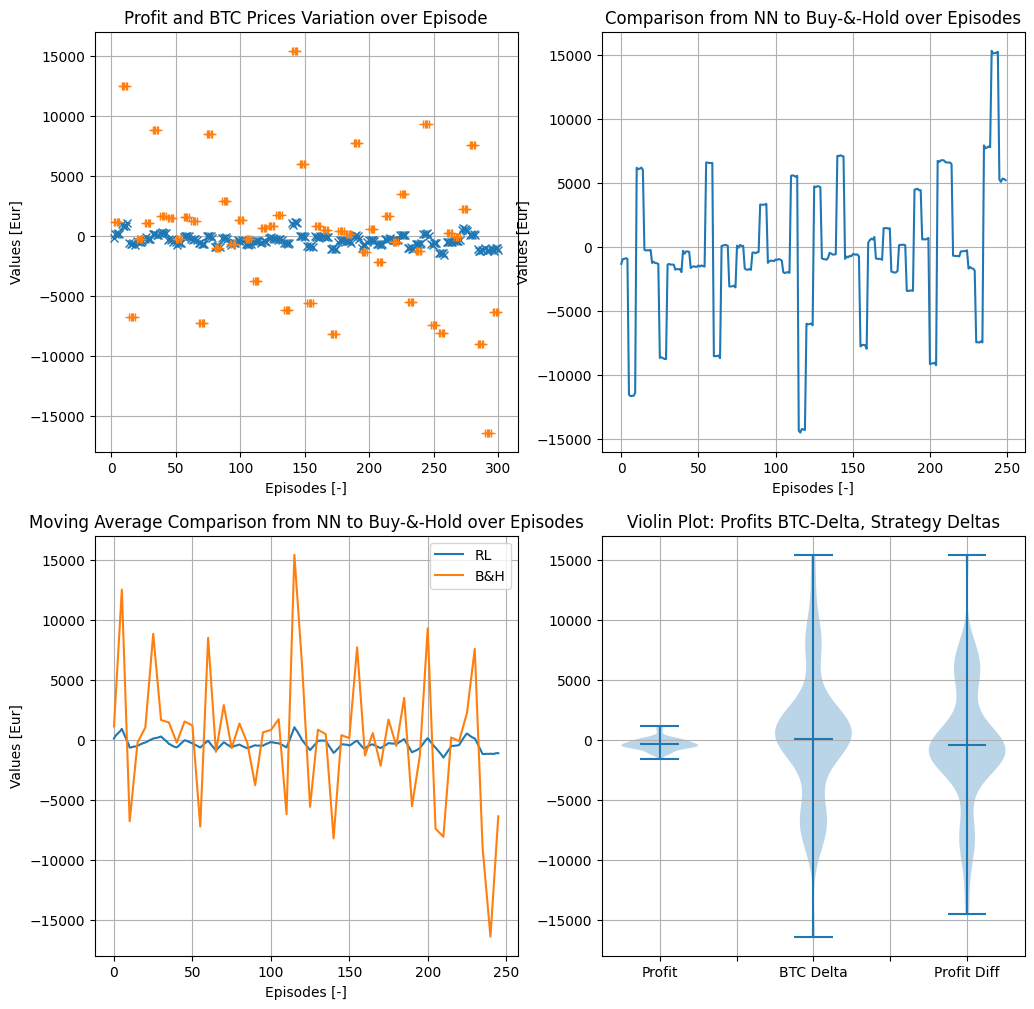

In [10]:
plot_overviews(episode, profit, delta_btc_price)

In [11]:
# Pick Episode
print(f"max episode = {len(ep_frame)//670 -1 }")

max episode = 249


C:\Users\romy_\AppData\Local\Temp\ipykernel_8440\3018370147.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = [np.fromstring(x[1:-1], dtype=np.float, sep=' ') for x  in dataframe.reward[ep*670:(ep+1)*670]]
C:\Users\romy_\AppData\Local\Temp\ipykernel_8440\3018370147.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = [np.fromst

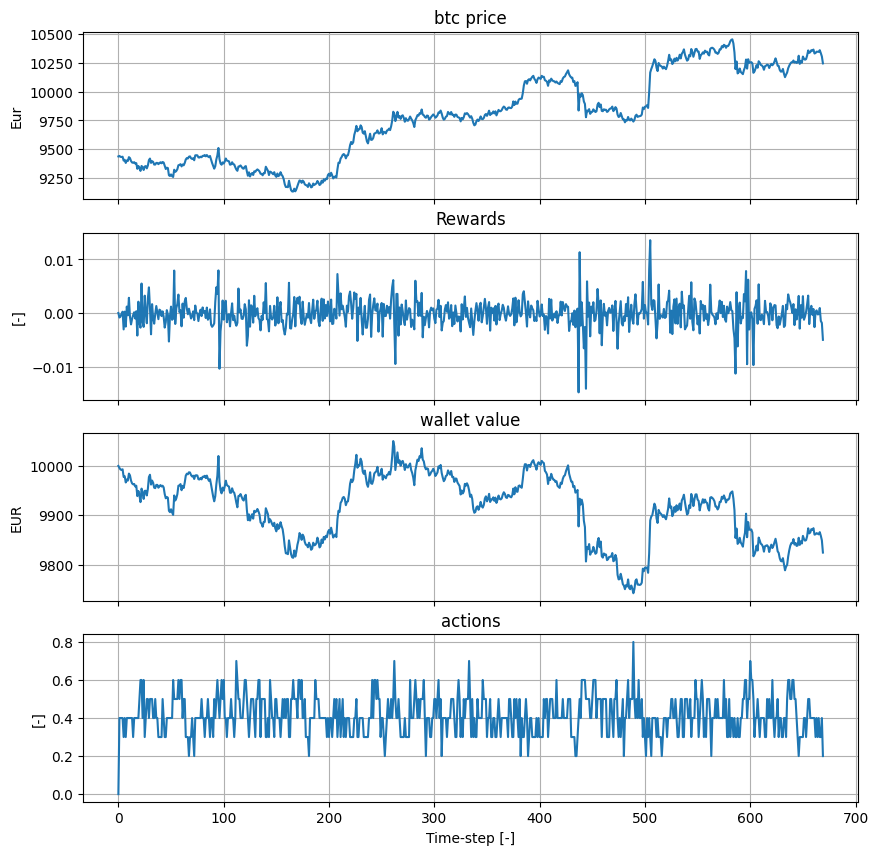

In [12]:
ep=60
plot_episode_info(ep_frame, ep)

## Data Analysis: 20230424_070731

In [13]:
data_folder = os.path.join(base_folder, '20230424_070731')
train_frame, ep_frame = get_train_data(data_folder, algorithm=algo, trial=0, return_df=True)
print(train_frame.shape, ep_frame.shape)

{'action_domain': [0.0, 1.0],
 'action_space': 1,
 'algorithm': 'DRL_trial_0',
 'asset': 'BTC',
 'batch_size': 16,
 'data_source': 'BTC_histData_dt1800.0s_20220825_0629',
 'episodes': 50,
 'epoch': 2,
 'epsilon': 0.5,
 'epsilon_decay': 0.75,
 'epsilon_final': 0.01,
 'fee': 0.001,
 'from_checkpoint': None,
 'gamma': 0.95,
 'learning_rate': 1e-07,
 'loss_method': 'stantard_loss',
 'money': 10000,
 'obs_space': [8, 20],
 'reward_function': 'reward_differential_sharpe_ratio',
 'runs_p_eps': 5,
 'trainer': 'DRLTrainer'}
(159523, 9) (159460, 23)


In [14]:
episode, profit, delta_btc_price = get_profits_every_episode(ep_frame)
profit_diff = [profit[i] - delta_btc_price[i] for i in range(len(episode))]

np.mean(profit), np.std(profit), np.mean(delta_btc_price), np.std(delta_btc_price)
-325.1720168067227 787.2133395842972 605.3022689075627 5163.831479531444


C:\Users\romy_\AppData\Local\Temp\ipykernel_8440\383711849.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1][1].set_xticklabels([" ", "Profit"," ",  "BTC Delta"," ", "Profit Diff"])


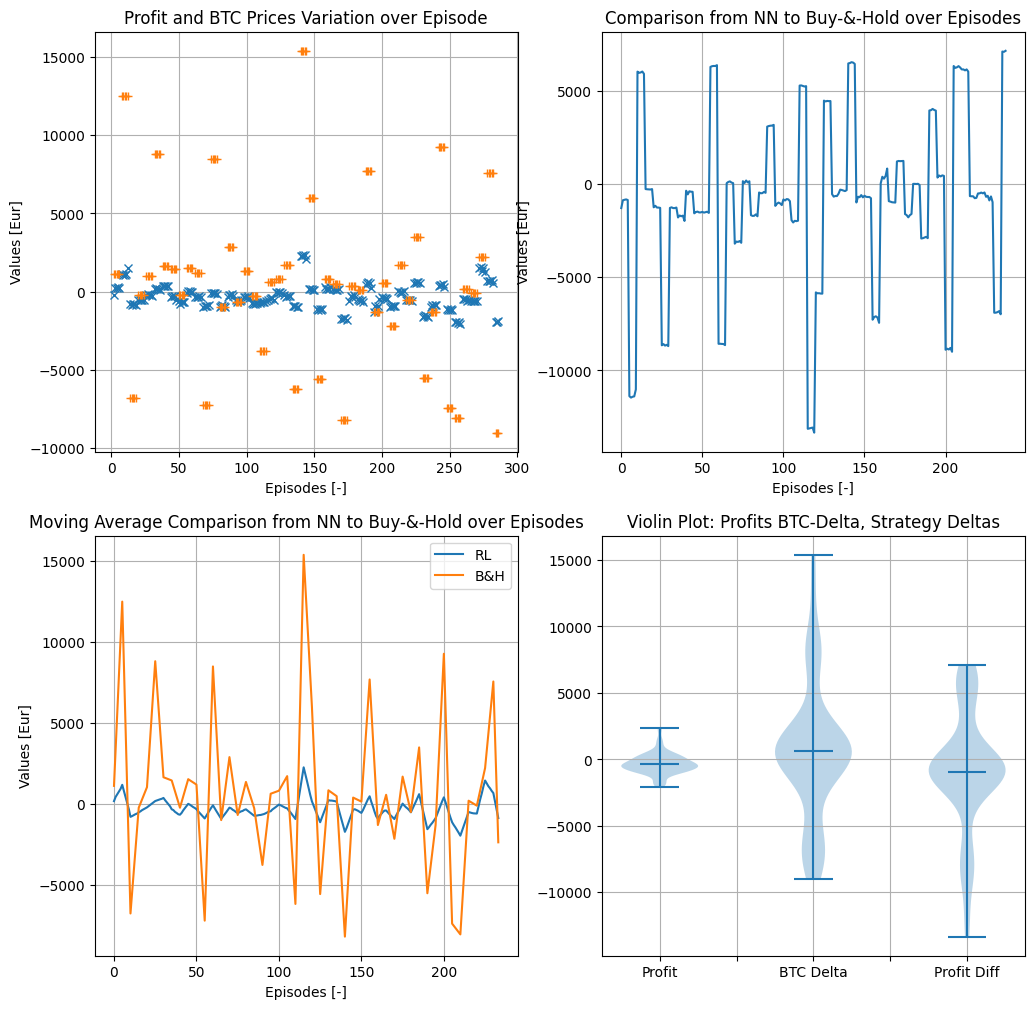

In [15]:
plot_overviews(episode, profit, delta_btc_price)

In [16]:
# Pick Episode
print(f"max episode = {len(ep_frame)//670 -1 }")

max episode = 237


C:\Users\romy_\AppData\Local\Temp\ipykernel_8440\3018370147.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = [np.fromstring(x[1:-1], dtype=np.float, sep=' ') for x  in dataframe.reward[ep*670:(ep+1)*670]]
C:\Users\romy_\AppData\Local\Temp\ipykernel_8440\3018370147.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = [np.fromst

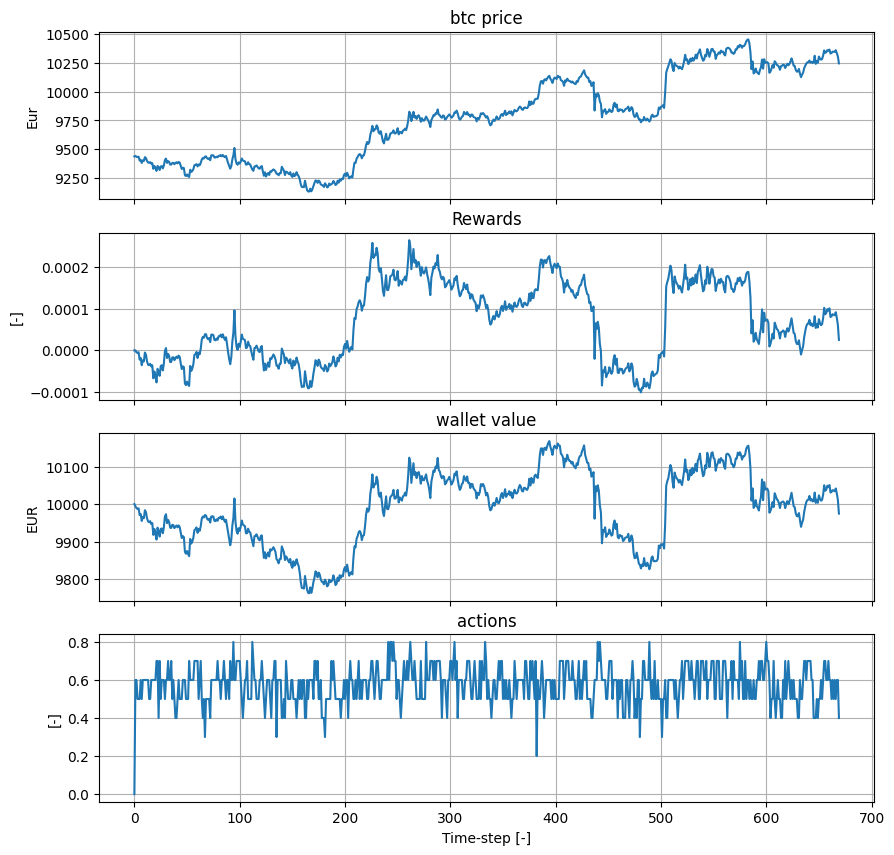

In [17]:
ep=60
plot_episode_info(ep_frame, ep)

## Data Analysis: 20230429_200559

In [18]:
data_folder = os.path.join(base_folder, '20230429_200559')
train_frame, ep_frame = get_train_data(data_folder, algorithm=algo, trial=0, return_df=True)
print(train_frame.shape, ep_frame.shape)

{'action_domain': [0.0, 1.0],
 'action_space': 1,
 'algorithm': 'DRL_trial_0',
 'asset': 'BTC',
 'batch_size': 16,
 'data_source': 'BTC_histData_dt1800.0s_20220825_0629',
 'episodes': 50,
 'epoch': 2,
 'epsilon': 0.5,
 'epsilon_decay': 0.75,
 'epsilon_final': 0.01,
 'fee': 0.001,
 'from_checkpoint': None,
 'gamma': 0.95,
 'learning_rate': 1e-06,
 'loss_method': 'stantard_loss',
 'money': 10000,
 'obs_space': [8, 20],
 'reward_function': 'compute_reward_from_tutor',
 'runs_p_eps': 5,
 'trainer': 'DRLTrainer'}
(167250, 9) (167500, 23)


In [19]:
episode, profit, delta_btc_price = get_profits_every_episode(ep_frame)
profit_diff = [profit[i] - delta_btc_price[i] for i in range(len(episode))]

np.mean(profit), np.std(profit), np.mean(delta_btc_price), np.std(delta_btc_price)
48.634679999999996 1069.2197821488796 48.80179999999993 5706.867794250254


C:\Users\romy_\AppData\Local\Temp\ipykernel_8440\383711849.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1][1].set_xticklabels([" ", "Profit"," ",  "BTC Delta"," ", "Profit Diff"])


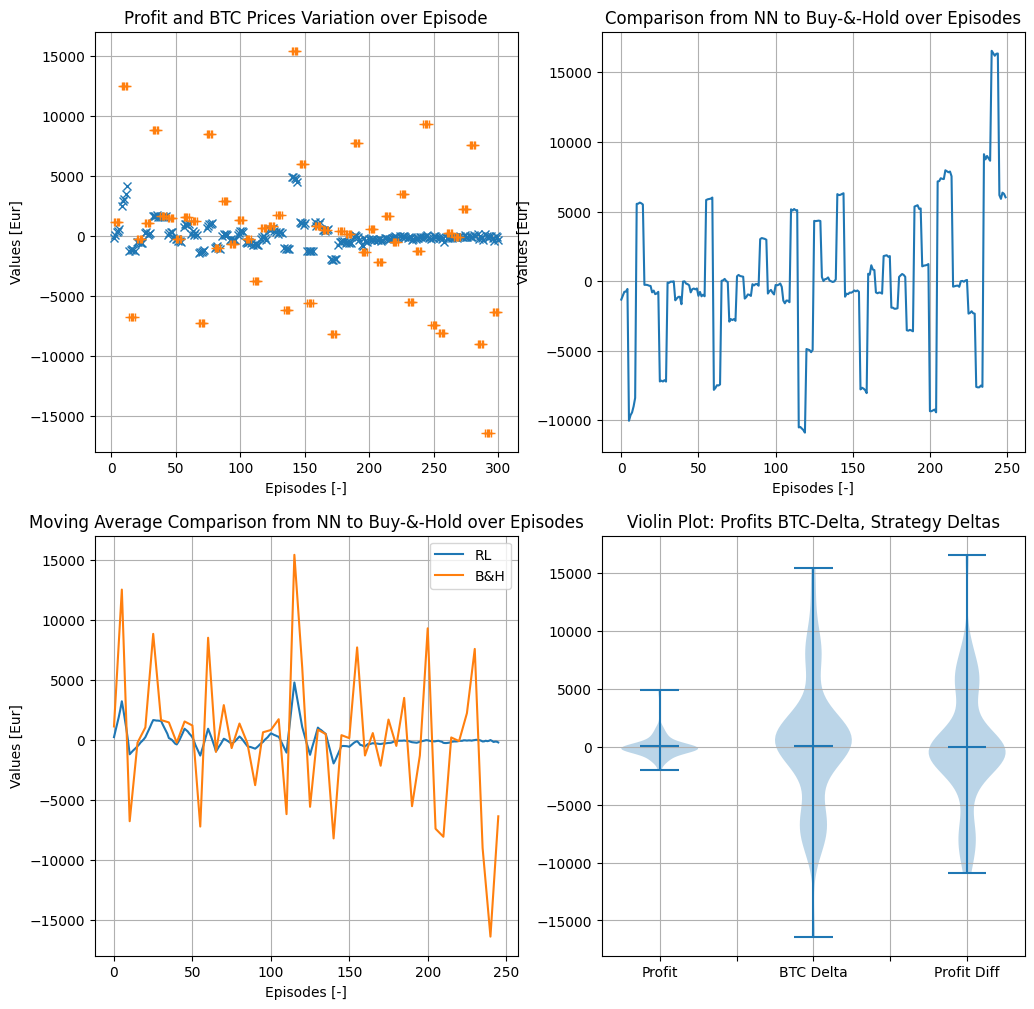

In [20]:
plot_overviews(episode, profit, delta_btc_price)

In [21]:
# Pick Episode
print(f"max episode = {len(ep_frame)//670 -1 }")

max episode = 249


C:\Users\romy_\AppData\Local\Temp\ipykernel_8440\3018370147.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = [np.fromstring(x[1:-1], dtype=np.float, sep=' ') for x  in dataframe.reward[ep*670:(ep+1)*670]]
C:\Users\romy_\AppData\Local\Temp\ipykernel_8440\3018370147.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = [np.fromst

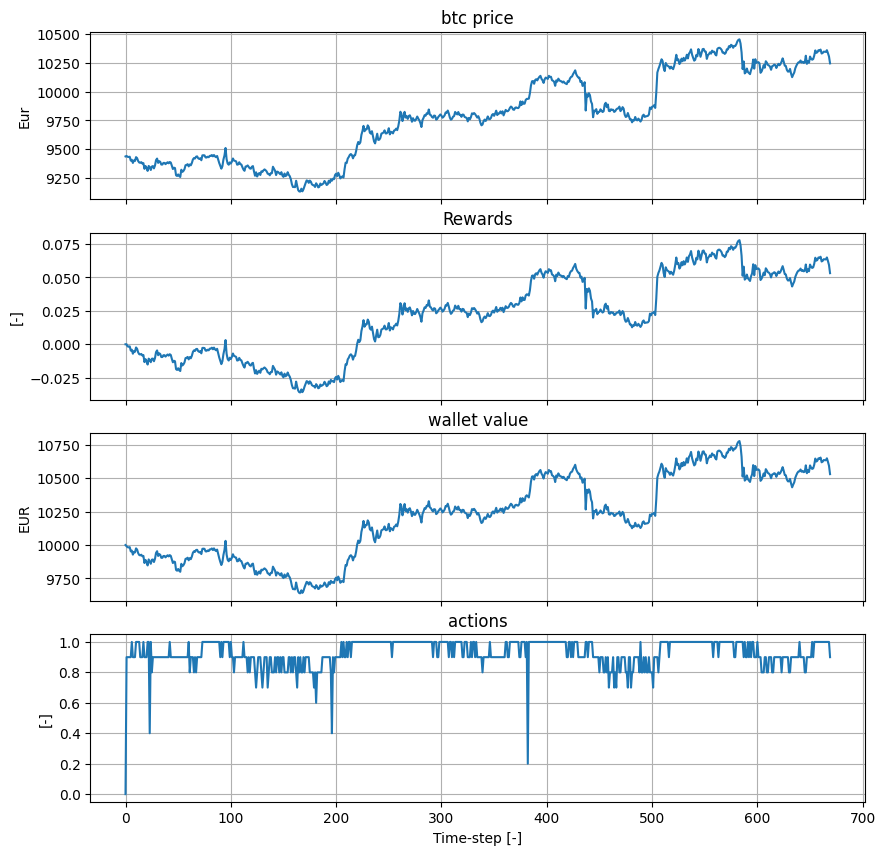

In [22]:
ep=60
plot_episode_info(ep_frame, ep)

## Data Analysis: 20230429_110440

In [23]:
data_folder = os.path.join(base_folder, '20230429_110440')
train_frame, ep_frame = get_train_data(data_folder, algorithm=algo, trial=0, return_df=True)
print(train_frame.shape, ep_frame.shape)

{'action_domain': [0.0, 1.0],
 'action_space': 1,
 'algorithm': 'DRL_trial_0',
 'asset': 'BTC',
 'batch_size': 16,
 'data_source': 'BTC_histData_dt1800.0s_20220825_0629',
 'episodes': 50,
 'epoch': 2,
 'epsilon': 0.5,
 'epsilon_decay': 0.75,
 'epsilon_final': 0.01,
 'fee': 0.001,
 'from_checkpoint': None,
 'gamma': 0.95,
 'learning_rate': 1e-06,
 'loss_method': 'stantard_loss',
 'money': 10000,
 'obs_space': [8, 20],
 'reward_function': 'reward_profit',
 'runs_p_eps': 5,
 'trainer': 'DRLTrainer'}
(167250, 9) (167500, 23)


In [24]:
episode, profit, delta_btc_price = get_profits_every_episode(ep_frame)
profit_diff = [profit[i] - delta_btc_price[i] for i in range(len(episode))]

np.mean(profit), np.std(profit), np.mean(delta_btc_price), np.std(delta_btc_price)
-354.76412000000005 496.33511861586584 48.80179999999993 5706.867794250254


C:\Users\romy_\AppData\Local\Temp\ipykernel_8440\383711849.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1][1].set_xticklabels([" ", "Profit"," ",  "BTC Delta"," ", "Profit Diff"])


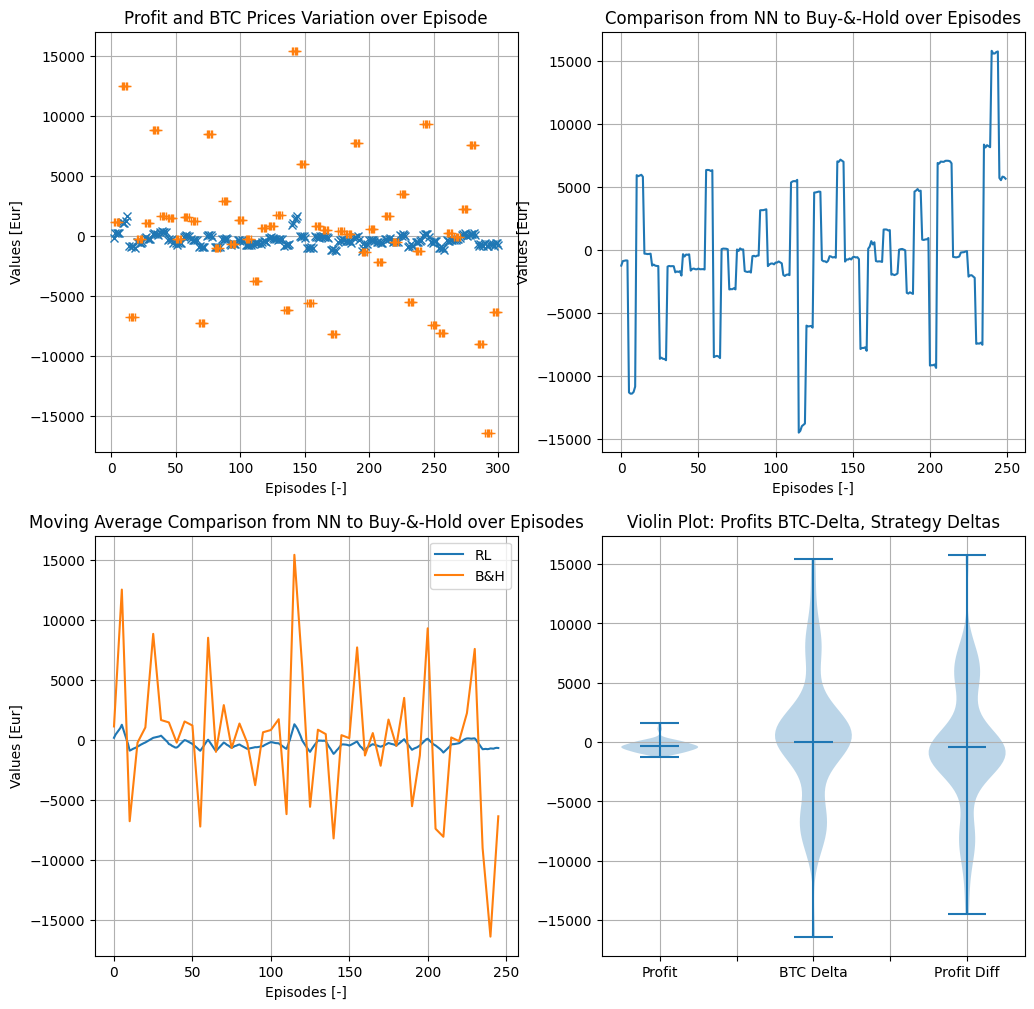

In [25]:
plot_overviews(episode, profit, delta_btc_price)

In [26]:
# Pick Episode
print(f"max episode = {len(ep_frame)//670 -1 }")

max episode = 249


C:\Users\romy_\AppData\Local\Temp\ipykernel_8440\3018370147.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = [np.fromstring(x[1:-1], dtype=np.float, sep=' ') for x  in dataframe.reward[ep*670:(ep+1)*670]]
C:\Users\romy_\AppData\Local\Temp\ipykernel_8440\3018370147.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = [np.fromst

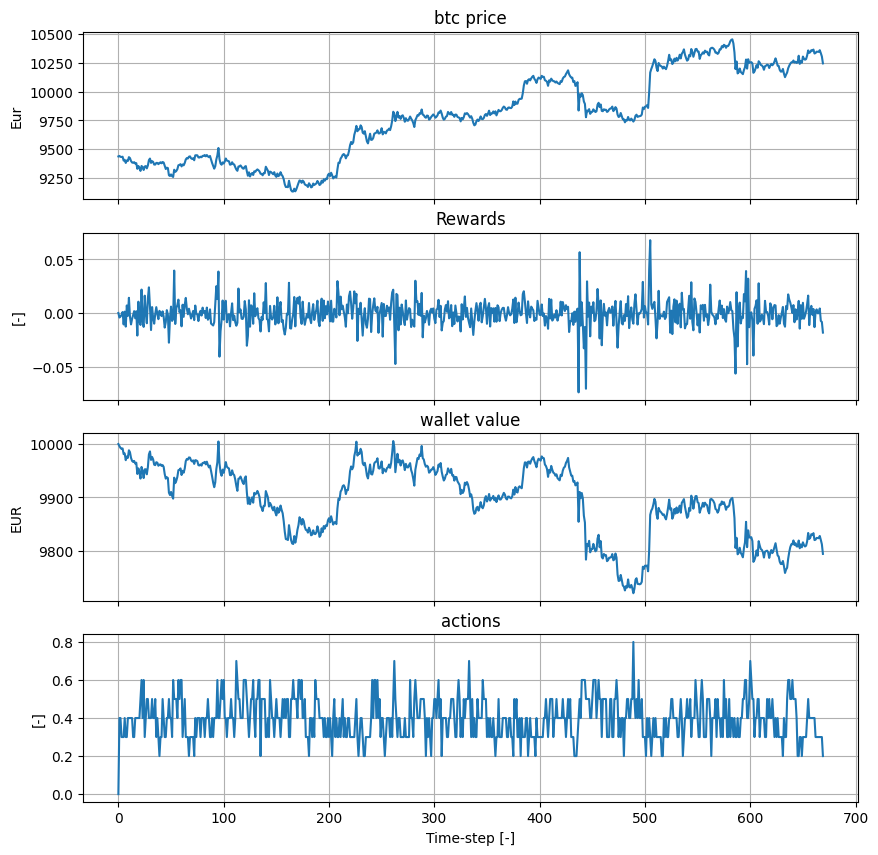

In [27]:
ep=60
plot_episode_info(ep_frame, ep)

## Data Analysis: 20230423_174023

In [28]:
data_folder = os.path.join(base_folder, '20230423_174023')
train_frame, ep_frame = get_train_data(data_folder, algorithm=algo, trial=0, return_df=True)
print(train_frame.shape, ep_frame.shape)

{'action_domain': [0.0, 1.0],
 'action_space': 1,
 'algorithm': 'DRL_trial_0',
 'asset': 'BTC',
 'batch_size': 16,
 'data_source': 'BTC_histData_dt1800.0s_20220825_0629',
 'episodes': 50,
 'epoch': 2,
 'epsilon': 0.5,
 'epsilon_decay': 0.75,
 'epsilon_final': 0.01,
 'fee': 0.001,
 'from_checkpoint': None,
 'gamma': 0.95,
 'learning_rate': 1e-05,
 'loss_method': 'stantard_loss',
 'money': 10000,
 'obs_space': [8, 20],
 'reward_function': 'reward_profit',
 'runs_p_eps': 5,
 'trainer': 'DRLTrainer'}
(167250, 9) (167500, 23)


In [29]:
episode, profit, delta_btc_price = get_profits_every_episode(ep_frame)
profit_diff = [profit[i] - delta_btc_price[i] for i in range(len(episode))]

np.mean(profit), np.std(profit), np.mean(delta_btc_price), np.std(delta_btc_price)
-224.46728000000002 673.4340050313778 48.80179999999993 5706.867794250254


C:\Users\romy_\AppData\Local\Temp\ipykernel_8440\383711849.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1][1].set_xticklabels([" ", "Profit"," ",  "BTC Delta"," ", "Profit Diff"])


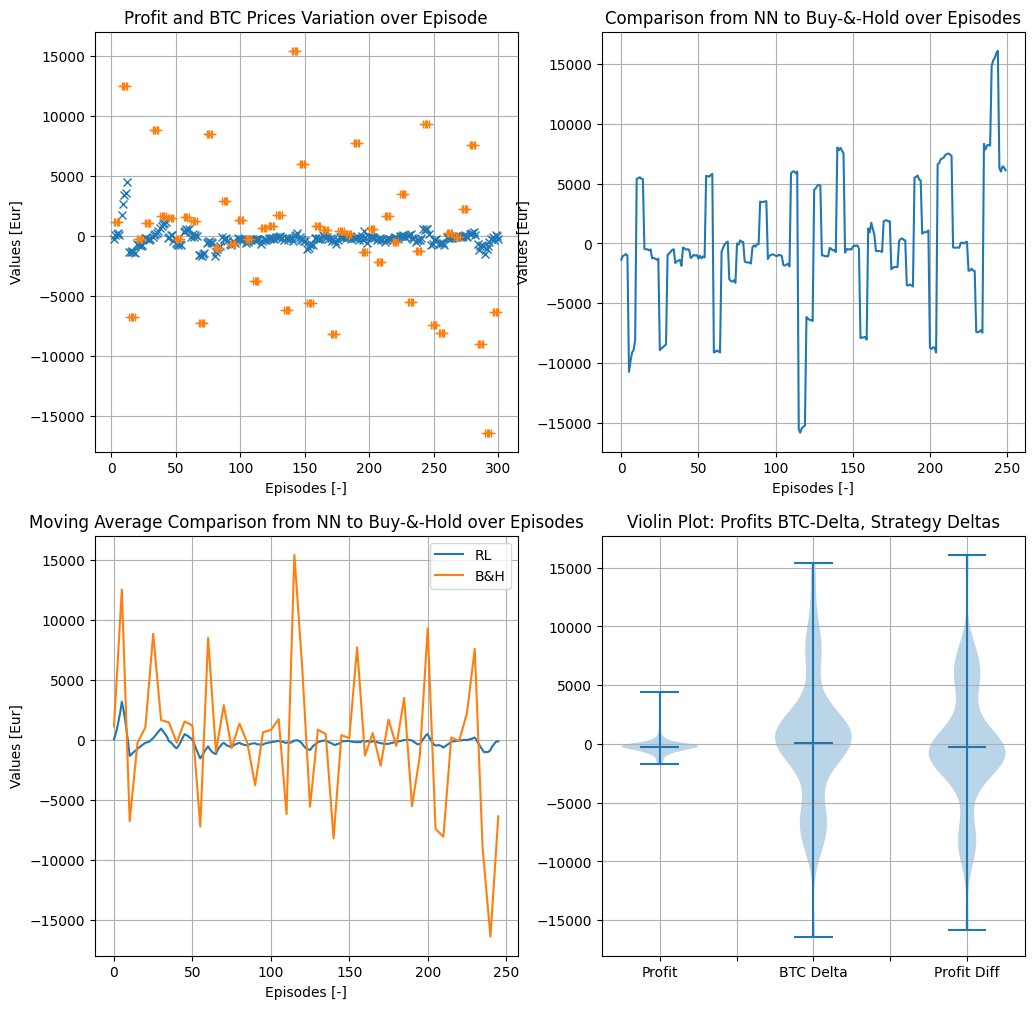

In [30]:
plot_overviews(episode, profit, delta_btc_price)

In [31]:
# Pick Episode
print(f"max episode = {len(ep_frame)//670 -1 }")

max episode = 249


C:\Users\romy_\AppData\Local\Temp\ipykernel_8440\3018370147.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = [np.fromstring(x[1:-1], dtype=np.float, sep=' ') for x  in dataframe.reward[ep*670:(ep+1)*670]]
C:\Users\romy_\AppData\Local\Temp\ipykernel_8440\3018370147.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = [np.fromst

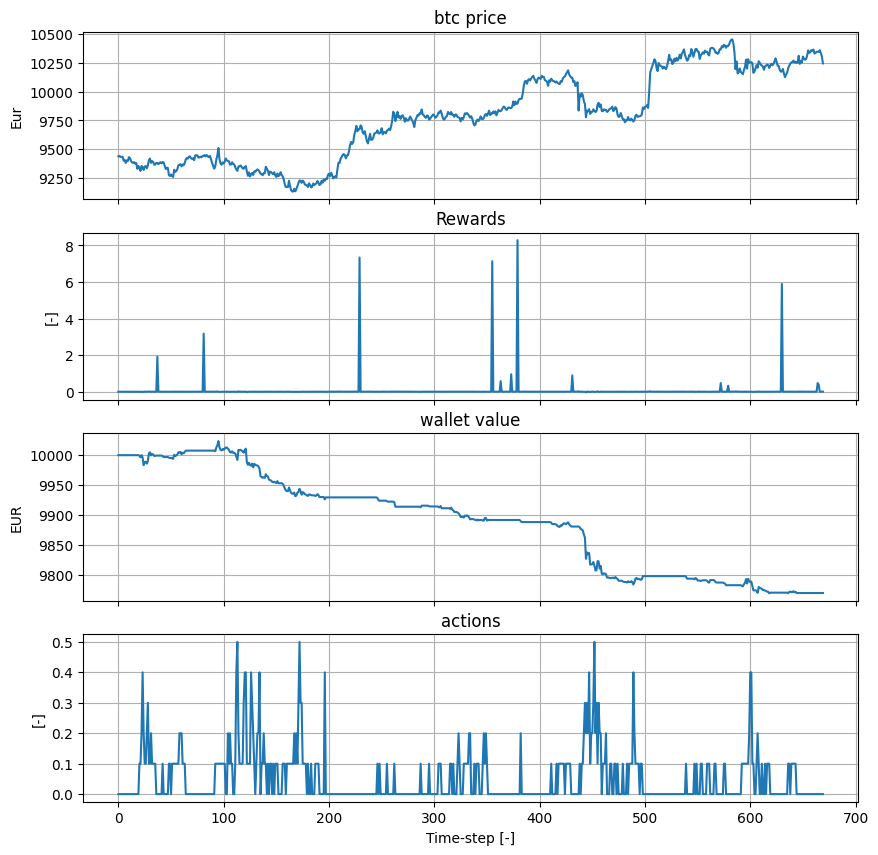

In [32]:
ep=60
plot_episode_info(ep_frame, ep)

## Data Analysis: 20230420_083508

In [33]:
data_folder = os.path.join(base_folder, '20230420_083508')
train_frame, ep_frame = get_train_data(data_folder, algorithm=algo, trial=0, return_df=True)
print(train_frame.shape, ep_frame.shape)

{'action_domain': [0.0, 1.0],
 'action_space': 1,
 'algorithm': 'DRL_trial_8',
 'asset': 'BTC',
 'batch_size': 32,
 'data_source': 'BTC_histData_dt1800.0s_20220825_0629',
 'episodes': 50,
 'epoch': 2,
 'epsilon': 0.5,
 'epsilon_decay': 0.75,
 'epsilon_final': 0.01,
 'fee': 0.001,
 'from_checkpoint': None,
 'gamma': 0.95,
 'learning_rate': 1e-05,
 'loss_method': 'stantard_loss',
 'money': 10000,
 'obs_space': [8, 20],
 'reward_function': 'reward_profit',
 'runs_p_eps': 5,
 'trainer': 'DRLTrainer'}
(167250, 9) (167500, 23)


In [34]:
episode, profit, delta_btc_price = get_profits_every_episode(ep_frame)
profit_diff = [profit[i] - delta_btc_price[i] for i in range(len(episode))]

np.mean(profit), np.std(profit), np.mean(delta_btc_price), np.std(delta_btc_price)
-272.10812000000004 1102.4263441340947 -32.70560000000021 5271.4108584116875


C:\Users\romy_\AppData\Local\Temp\ipykernel_8440\383711849.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1][1].set_xticklabels([" ", "Profit"," ",  "BTC Delta"," ", "Profit Diff"])


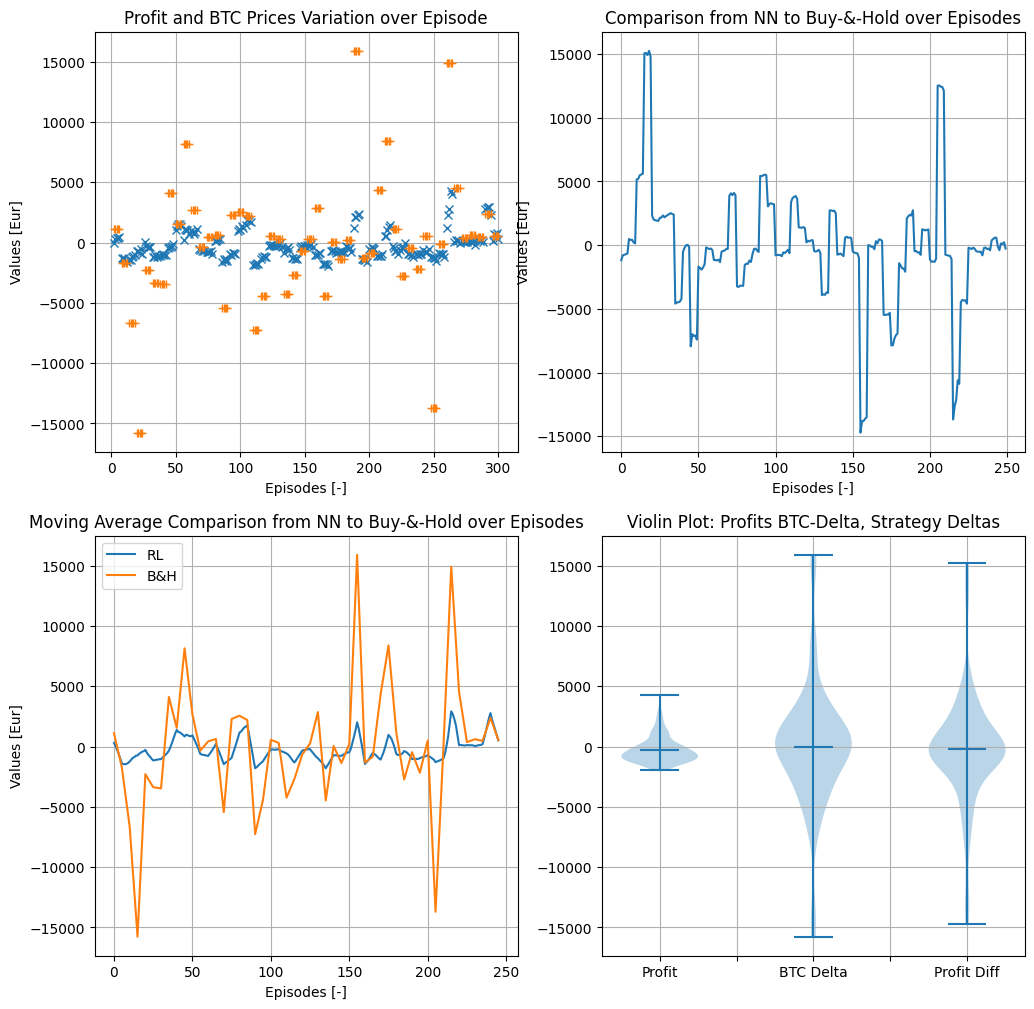

In [35]:
plot_overviews(episode, profit, delta_btc_price)

In [36]:
# Pick Episode
print(f"max episode = {len(ep_frame)//670 -1 }")

max episode = 249


C:\Users\romy_\AppData\Local\Temp\ipykernel_8440\3018370147.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = [np.fromstring(x[1:-1], dtype=np.float, sep=' ') for x  in dataframe.reward[ep*670:(ep+1)*670]]
C:\Users\romy_\AppData\Local\Temp\ipykernel_8440\3018370147.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = [np.fromst

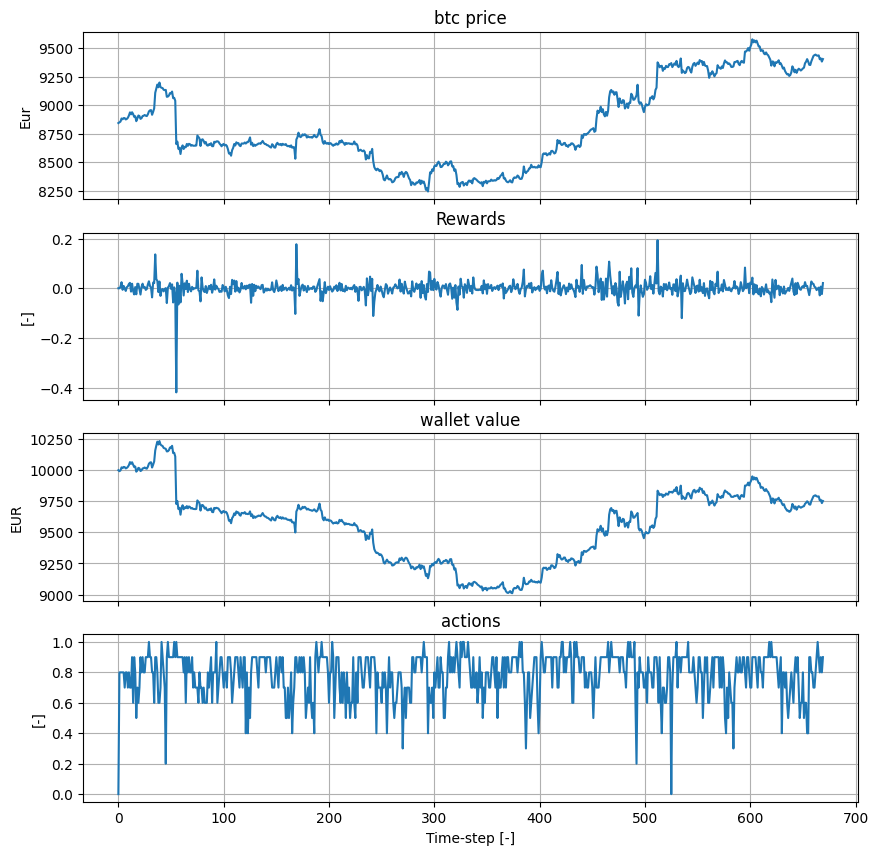

In [37]:
ep=60
plot_episode_info(ep_frame, ep)

## Data Analysis: 20230420_195053

In [38]:
data_folder = os.path.join(base_folder, '20230420_195053')
train_frame, ep_frame = get_train_data(data_folder, algorithm=algo, trial=0, return_df=True)
print(train_frame.shape, ep_frame.shape)

{'action_domain': [0.0, 1.0],
 'action_space': 1,
 'algorithm': 'DRL_trial_9',
 'asset': 'BTC',
 'batch_size': 16,
 'data_source': 'BTC_histData_dt1800.0s_20220825_0629',
 'episodes': 50,
 'epoch': 2,
 'epsilon': 0.5,
 'epsilon_decay': 0.75,
 'epsilon_final': 0.01,
 'fee': 0.001,
 'from_checkpoint': None,
 'gamma': 0.95,
 'learning_rate': 1e-05,
 'loss_method': 'stantard_loss',
 'money': 10000,
 'obs_space': [8, 20],
 'reward_function': 'reward_profit',
 'runs_p_eps': 5,
 'trainer': 'DRLTrainer'}
(167250, 9) (167500, 23)


In [39]:
episode, profit, delta_btc_price = get_profits_every_episode(ep_frame)
profit_diff = [profit[i] - delta_btc_price[i] for i in range(len(episode))]

np.mean(profit), np.std(profit), np.mean(delta_btc_price), np.std(delta_btc_price)
-86.40012000000004 1377.5505611829954 48.80179999999993 5706.867794250254


C:\Users\romy_\AppData\Local\Temp\ipykernel_8440\383711849.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1][1].set_xticklabels([" ", "Profit"," ",  "BTC Delta"," ", "Profit Diff"])


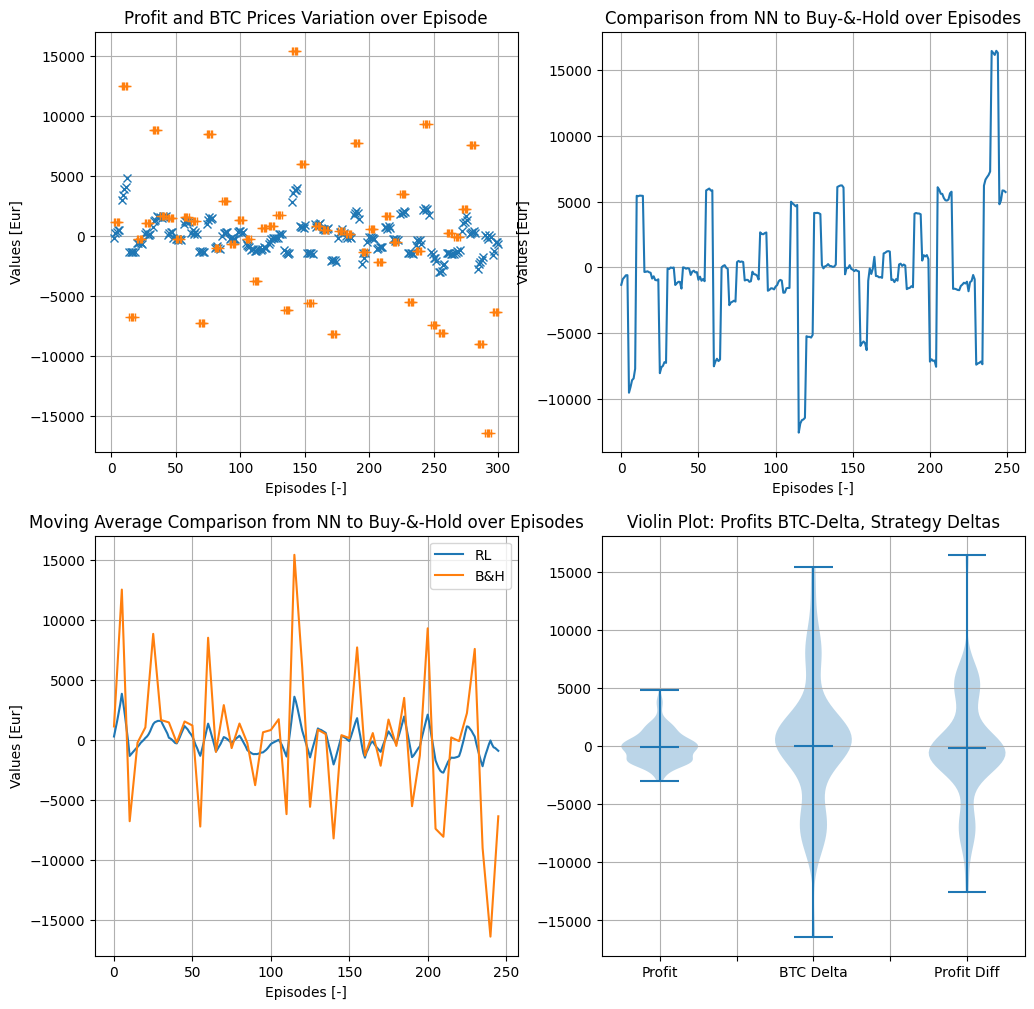

In [40]:
plot_overviews(episode, profit, delta_btc_price)

In [41]:
# Pick Episode
print(f"max episode = {len(ep_frame)//670 -1 }")

max episode = 249


C:\Users\romy_\AppData\Local\Temp\ipykernel_8440\3018370147.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = [np.fromstring(x[1:-1], dtype=np.float, sep=' ') for x  in dataframe.reward[ep*670:(ep+1)*670]]
C:\Users\romy_\AppData\Local\Temp\ipykernel_8440\3018370147.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = [np.fromst

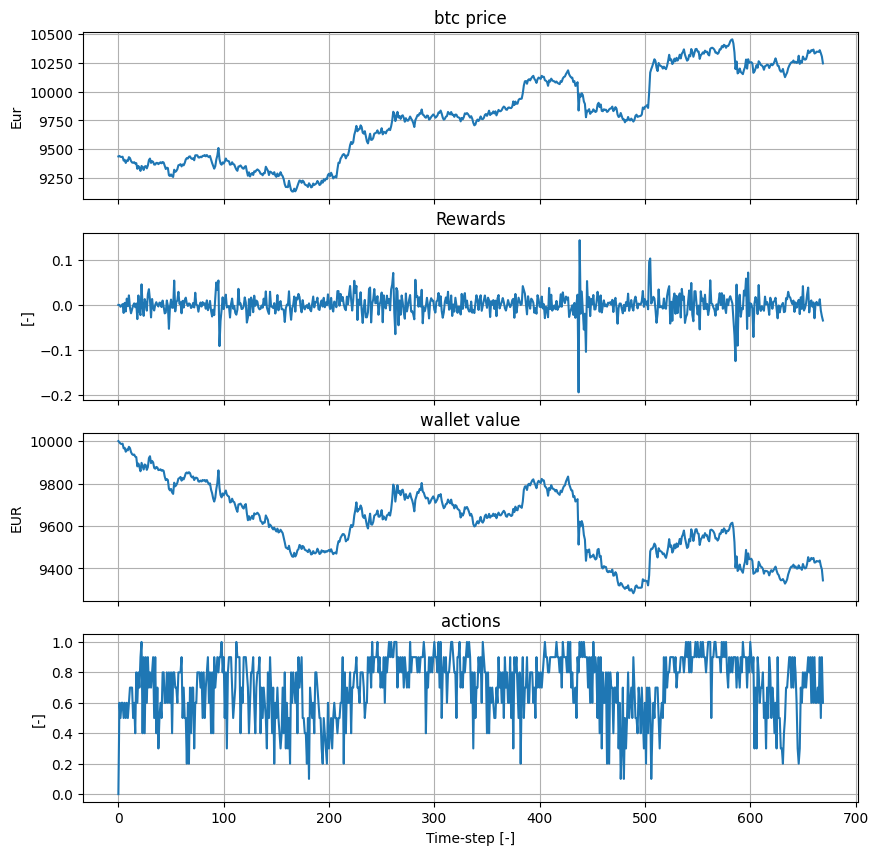

In [42]:
ep=60
plot_episode_info(ep_frame, ep)